## Image resizing

Use conda env solaris

image size 512 with reflect
and without reflect

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
import geopandas as gpd
from PIL import Image
import PIL.Image as pil_image
import cv2
from pathlib import Path
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import pandas as pd
import math
import shutil

In [39]:
data_dir = Path('data_04')
pd_dir = Path('data')
d_pth = 'data_04'
colombia_rural = Path(f'{d_pth}/stac/colombia/borde_rural')
colombia_soacha = Path(f'{d_pth}/stac/colombia/borde_soacha')

In [40]:
guatemala_mixco1 = Path(f'{d_pth}/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path(f'{d_pth}/stac/guatemala/mixco_3')

In [41]:
st_lucia_castries = Path(f'{d_pth}/stac/st_lucia/castries')
st_lucia_dennery = Path(f'{d_pth}/stac/st_lucia/dennery')
st_lucia_gros_islet = Path(f'{d_pth}/stac/st_lucia/gros_islet')

In [42]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [43]:
CV_RESIZE_IMAGES = True
PIL_RESIZE_IMAGES = False
#BORDER_WRAP
#BORDER_CONSTANT
#BORDER_REFLECT_101
BORDER = cv2.BORDER_CONSTANT
#RGB or L
IMG_COLOUR='RGB'
FLIPS=False

In [44]:
border = 'constant'

In [45]:
img_size=256

In [46]:
def create_df(data_path, json, country, region):
    df = gpd.read_file(data_path/json)
    e=[country] * len(df)
    f=[region] * len(df)
    df['country'] = e
    df['region'] = f
    return df

In [47]:
df_list=[]
path_list= [colombia_rural, colombia_soacha, guatemala_mixco1, guatemala_mixco3,
         st_lucia_castries, st_lucia_dennery, st_lucia_gros_islet]
json_list=['train-borde_rural.geojson','train-borde_soacha.geojson','train-mixco_1_and_ebenezer.geojson','train-mixco_3.geojson',
          'train-castries.geojson','train-dennery.geojson','train-gros_islet.geojson']
country_list=['colombia','colombia','guatemala','guatemala','st_lucia','st_lucia','st_lucia']
region_list=['borde_rural','borde_soacha','mixco_1_and_ebenezer','mixco_3','castries','dennery','gros_islet']
for data_path, json, country, region in zip(path_list,json_list,country_list,region_list):
    df_list.append(create_df(data_path, json, country, region))

In [48]:
df_all = pd.concat(df_list)

In [49]:
df_all.tail()

,id,roof_material,verified,geometry,country,region
1962,7a22ddec,healthy_metal,False,"POLYGON ((-60.95293 14.08097, -60.95289 14.080...",st_lucia,gros_islet
1963,7a2f73ea,healthy_metal,False,"POLYGON ((-60.94701 14.08085, -60.94705 14.080...",st_lucia,gros_islet
1964,7a34ffa4,healthy_metal,False,"POLYGON ((-60.95235 14.08003, -60.95239 14.080...",st_lucia,gros_islet
1965,7a41560a,healthy_metal,False,"POLYGON ((-60.94875 14.08058, -60.94875 14.080...",st_lucia,gros_islet
1966,7a283ad0,healthy_metal,False,"POLYGON ((-60.94869 14.08074, -60.94869 14.080...",st_lucia,gros_islet


In [50]:
#cant save to csv with geometry
df_all.drop(columns=['geometry'],inplace=True)

In [51]:
#df_all.to_csv(data_dir/'df_train_all.csv', index=False)

In [52]:
#note no geo json from st_lucia castries or gros_islet
df_t=[]
t_path_list= [colombia_rural, colombia_soacha, guatemala_mixco1, guatemala_mixco3, st_lucia_dennery]
t_json_list=['test-borde_rural.geojson','test-borde_soacha.geojson','test-mixco_1_and_ebenezer.geojson',
           'test-mixco_3.geojson','test-dennery.geojson']
t_country_list=['colombia','colombia','guatemala','guatemala','st_lucia']
t_region_list=['borde_rural','borde_soacha','mixco_1_and_ebenezer','mixco_3','dennery']
for data_path, json, country, region in zip(t_path_list,t_json_list,t_country_list,t_region_list):
    df_t.append(create_df(data_path, json, country, region))

In [53]:
df_test = pd.concat(df_t)

In [54]:
df_test.head()

,id,geometry,country,region
0,7a4d630a,"POLYGON ((-74.15900 4.55463, -74.15898 4.55470...",colombia,borde_rural
1,7a4bbbd6,"POLYGON ((-74.15955 4.55463, -74.15951 4.55474...",colombia,borde_rural
2,7a4ac744,"POLYGON ((-74.15892 4.55509, -74.15887 4.55507...",colombia,borde_rural
3,7a4881fa,"POLYGON ((-74.15887 4.55506, -74.15883 4.55505...",colombia,borde_rural
4,7a4aa4a8,"POLYGON ((-74.15882 4.55504, -74.15871 4.55500...",colombia,borde_rural


In [55]:
#cant save to csv with geometry
df_test.drop(columns=['geometry'],inplace=True)

In [56]:
#df_test.to_csv(data_dir/'df_test_all.csv', index=False)

#### get average image size

In [57]:
def img_type_av_sz(fn_list):
    widths = []
    heights = []
    for im in fn_list:
        #100 x faster than open_image(img_f)
        w,h=pil_image.open(im).size
        widths.append(w)
        heights.append(h)
    av_w = sum(widths)/len(widths)
    av_h = sum(heights)/len(heights)
    print(f'avg width: {av_w}, avg height: {av_h}, max w: {max(widths)}, min w: {min(widths)}, max h: {max(heights)}, min h: {min(heights)}')
    return widths, heights


In [58]:
path

PosixPath('data_02/colombia_borde_rural/cropped')

In [25]:
fnames = [path/'train'/f'{f}' for f in listdir(path/'train') if isfile(join(path/'train', f))]

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/rotated/clipped/reflect/256/train'

In [ ]:
test_fnames = [path/'train'/f'{f}' for f in listdir(path/'test') if isfile(join(path/'test', f))]

In [ ]:
#### data qc

In [59]:
path1=pd_dir/f'train/rotated/clipped/reflect/256/'
fnames = [path1/f'{f}' for f in listdir(path1) if isfile(join(path1, f))]
fnames = [str(i) for i in fnames if '.tif' in str(i)] 

In [60]:
fnames[0]

'data/train/rotated/clipped/reflect/256/7a234dfe_imgaug_3_3359.tif'

In [61]:
widths, heights=img_type_av_sz(fnames[0:200])

avg width: 256.0, avg height: 256.0, max w: 256, min w: 256, max h: 256, min h: 256


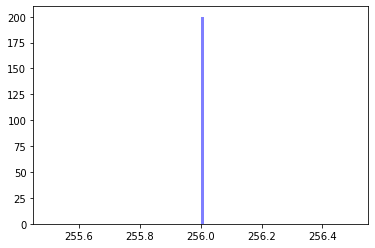

In [62]:
num_bins = 100
n, bins, patches = plt.hist(widths, num_bins, facecolor='blue', alpha=0.5)
plt.show()

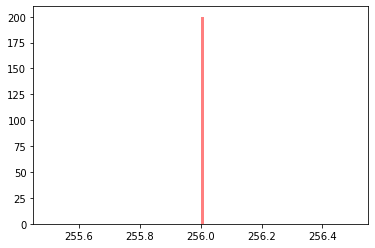

In [63]:
num_bins = 100
n, bins, patches = plt.hist(heights, num_bins, facecolor='red', alpha=0.5)
plt.show()

In [64]:
path2=data_dir/f'train/rotated/clipped/padded/reflect/256/'
fnames = [path2/f'{f}' for f in listdir(path2) if isfile(join(path2, f))]
fnames = [str(i) for i in fnames if '.tif' in str(i)] 

In [65]:
widths, heights=img_type_av_sz(fnames[0:200])

avg width: 256.0, avg height: 256.0, max w: 256, min w: 256, max h: 256, min h: 256


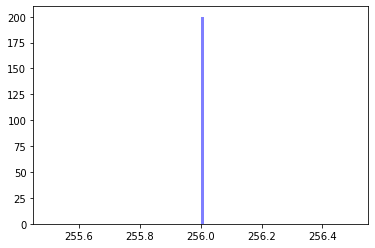

In [66]:
num_bins = 100
n, bins, patches = plt.hist(widths, num_bins, facecolor='blue', alpha=0.5)
plt.show()

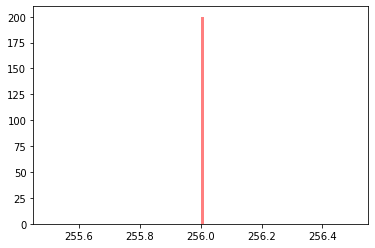

In [67]:
num_bins = 100
n, bins, patches = plt.hist(heights, num_bins, facecolor='red', alpha=0.5)
plt.show()

In [29]:
def resize_contain(image, size, resample=Image.LANCZOS, bg_color=(255, 255, 255, 255)):
    """
    Resize image according to size.
    image:      a Pillow image instance
    size:       a list of two integers [width, height]
    """
    img_format = image.format
    img = image.copy()
    img.thumbnail((size[0], size[1]), resample)
    background = Image.new('RGBA', (size[0], size[1]), bg_color)
    img_position = (
        int(math.ceil((size[0] - img.size[0]) / 2)),
        int(math.ceil((size[1] - img.size[1]) / 2))
    )
    background.paste(img, img_position)
    background.format = img_format
    return background.convert('RGBA')

In [30]:
def resize_to_max(fn_list, max_w, max_h):
    widths = []
    heights = []
    for im in fn_list:
        with pil_image.open(im) as image:
            w,h=image.size
            if (w > max_w) or (h > max_h):
                res_im = resize_contain(image, [max_w, max_h])
                name=str(im).split('.')[0]
                res_im.save(f'{name}_512.tif', image.format)

In [31]:
def resize_all(fn_list, max_w, max_h, data_path, all_path):
    ''' using Pillow to resize to max_w ot h'''
    widths = []
    heights = []
    for im in fn_list:
        with pil_image.open(im) as image:
            w,h=image.size
            res_im = resize_contain(image, [max_w, max_h])
            name=str(im).split('.')[0]
            name=name.split('/')[-1]
            res_im.save(f'{data_path}/{name}.tif', image.format)
            shutil.copyfile(f'{data_path}/{name}.tif', all_path/f'{name}.tif')

In [32]:
def save_img(img, data_path, all_path, name):
    img.save(f'{all_path}/{name}.tif')
    #shutil.copyfile(f'{data_path}/{name}.tif', all_path/f'{name}.tif')

In [33]:
def pil_image_flips(img, data_path, all_path, name):
    '''
    out = im.transpose(Image.FLIP_LEFT_RIGHT)
    out = im.transpose(Image.FLIP_TOP_BOTTOM)
    out = im.transpose(Image.ROTATE_90)
    out = im.transpose(Image.ROTATE_180)
    out = im.transpose(Image.ROTATE_270)
    '''
    images=[]
    names=[]
    
    im_x=img.transpose(Image.FLIP_LEFT_RIGHT)
    im_xy=im_x.transpose(Image.FLIP_TOP_BOTTOM)
    im_y=im_xy.transpose(Image.FLIP_LEFT_RIGHT)
    im_90=img.transpose(Image.ROTATE_90)
    im_90x=im_90.transpose(Image.FLIP_LEFT_RIGHT)
    im_270=img.transpose(Image.ROTATE_270)
    im_270x=im_270.transpose(Image.FLIP_LEFT_RIGHT)
    images.extend([img, im_x,im_xy,im_y,im_90,im_90x,im_270,im_270x])
    names.extend([name, name+'_x',name+'_xy',name+'_y',name+'_90',name+'_90x',name+'_270',name+'_270x'])
    return images, names

#### OpenCV

In [34]:
def cv_resize_all(fn_list, max_size, data_path, all_path, color, border, flips):
    ''' using OpenCV to resize to max_w ot h'''
    print(f'resizing: {len(fn_list)} images to: {max_size} with OpenCV border: {border}')
    widths = []
    heights = []
    for i, im in enumerate(fn_list):
        img = cv2.imread(str(im))
        old_size = img.shape[:2] # old_size is in (height, width) format
        ratio = float(max_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])
        # new_size should be in (width, height) format
        img = cv2.resize(img, (new_size[1], new_size[0])) 
        delta_w = max_size - new_size[1]
        delta_h = max_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        new_im = cv2.copyMakeBorder(img, top, bottom, left, right, border,
    value=color)
        name=str(im).split('.')[0]
        name=name.split('/')[-1]
        if i % 1000 == 0:
            print(f'saving {i}th image to: {all_path}/{name}.tif')
        #write np array to image usinf PIL
        pim = Image.fromarray(new_im)
        if flips:
            images, names=pil_image_flips(pim, data_path, all_path, name)
            for img, name in zip(images, names):
                save_img(pim, data_path, all_path, name)
        else:
            save_img(pim, data_path, all_path, name)

In [35]:
fnames[0]

PosixPath('data_02/colombia_borde_rural/cropped/train/7a1e7446.tif')

In [36]:
train_dir = Path(f'{d_pth}/train')
train_dir.mkdir(exist_ok=True)
test_dir = Path(f'{d_pth}/test')
test_dir.mkdir(exist_ok=True)

#### PIL gen resized images

In [37]:
train_sized_dir = Path(f'{d_pth}/train/{img_size}')
train_sized_dir.mkdir(exist_ok=True)
test_sized_dir = Path(f'{d_pth}/test/{img_size}')
test_sized_dir.mkdir(exist_ok=True)

#### OpenCV gen resized images

In [38]:
train_cv_dir = Path(f'{d_pth}/train/rotated')
train_cv_dir.mkdir(exist_ok=True)
train_cv_dir = Path(f'{d_pth}/train/rotated/clipped')
train_cv_dir.mkdir(exist_ok=True)
train_cv_dir = Path(f'{d_pth}/train/rotated/clipped/{border}')
train_cv_dir.mkdir(exist_ok=True)
train_cv_dir = Path(f'{d_pth}/train/rotated/clipped/{border}/{img_size}')
train_cv_dir.mkdir(exist_ok=True)
train_cv_dir = Path(f'{d_pth}/train/rotated/clipped/{img_size}')
train_cv_dir.mkdir(exist_ok=True)
test_cv_dir = Path(f'{d_pth}/test/rotated')
test_cv_dir.mkdir(exist_ok=True)
test_cv_dir = Path(f'{d_pth}/test/rotated/clipped')
test_cv_dir.mkdir(exist_ok=True)
test_cv_dir = Path(f'{d_pth}/test/rotated/clipped/{border}')
test_cv_dir.mkdir(exist_ok=True)
test_cv_dir = Path(f'{d_pth}/test/rotated/clipped/{border}/{img_size}')
test_cv_dir.mkdir(exist_ok=True)

### resize all images

In [39]:
def pil_resize_to(fnames, test_fnames, size=256):
    for c, r in zip(country_list, region_list):
        p=data_dir/f'{c}_{r}/cropped/'
        t_dir = p/f'train/{size}'
        t_dir.mkdir(exist_ok=True)
        resize_all(fnames, size,size, data_path=f'{p}/train/{size}', all_path=data_dir/f'train/{size}')
        if r.strip() not in ['castries','gros_islet']:
            t_dir = p/f'test/{size}'
            t_dir.mkdir(exist_ok=True)
            resize_all(test_fnames, size, size, data_path=f'{p}/test/{size}', all_path=data_dir/f'test/{size}')

In [40]:
def cv_resize_to(fnames, test_fnames, color, size=256, flips=None):
    for c, r in zip(country_list, region_list):
        print(f'--cv_resize_to {c} {r}')
        p=data_dir/f'{c}_{r}/cropped/'
        t_dir = p/f'train/rotated/clipped/{size}'
        t_dir.mkdir(exist_ok=True)
        t_dir = p/f'train/rotated/clipped/{size}'
        t_dir.mkdir(exist_ok=True)
        cv_resize_all(fnames, size, data_path=f'{p}/train/rotated/clipped/{size}', all_path=data_dir/f'train/rotated/clipped/{border}/{size}', color=color, border=BORDER, flips=flips)
        if r.strip() not in ['castries','gros_islet']:
            t_dir = p/f'test/rotated/clipped/{size}'
            t_dir.mkdir(exist_ok=True)
            t_dir = p/f'test/rotated/clipped/{size}'
            t_dir.mkdir(exist_ok=True)
            cv_resize_all(test_fnames, size, data_path=f'{p}/test/rotated/clipped/{size}', all_path=data_dir/f'test/rotated/clipped/{border}/{size}', color=color, border=BORDER, flips=flips)

In [41]:
if PIL_RESIZE_IMAGES:
    fl=[]
    tl=[]
    train_flat=[]
    test_flat=[]
    for c, r in zip(country_list, region_list):
        p=data_dir/f'{c}_{r}/cropped/'
        fn = get_image_files(p/'train')
        fl.append(fn)
        if r.strip() not in ['castries','gros_islet']:
            tn = get_image_files(p/'test')
            tl.append(tn)
    train_flat = [item for sublist in fl for item in sublist]
    test_flat = [item for sublist in tl for item in sublist]
    resize_to(fnames=train_flat, test_fnames=test_flat, size=img_size)

In [42]:
if CV_RESIZE_IMAGES:
    #black for padding not covered by reflection
    color = [0, 0, 0]
    fl=[]
    tl=[]
    train_flat=[]
    test_flat=[]
    for c, r in zip(country_list, region_list):
        p=data_dir/f'{c}_{r}/cropped'
        pd = p/'train/rotated/clipped'
        fn=[pd/f'{f}' for f in listdir(pd) if isfile(join(pd, f))]
        assert (len(fn)>0)
        fl.append(fn)
        if r.strip() not in ['castries','gros_islet']:
            print(f'{c} region {r} test gen')
            pd = p/'test/rotated/clipped'
            tn = [pd/f'{f}' for f in listdir(pd) if isfile(join(pd, f))]
            assert (len(tn)>0)
            tl.append(tn)
    train_flat = [item for sublist in fl for item in sublist]
    test_flat = [item for sublist in tl for item in sublist]
    print(f'{len(train_flat)} train images; {len(test_flat)} test images')
    cv_resize_to(fnames=train_flat, test_fnames=test_flat, color=color, size=img_size, flips=FLIPS)

colombia region borde_rural test gen
colombia region borde_soacha test gen
guatemala region mixco_1_and_ebenezer test gen
guatemala region mixco_3 test gen
st_lucia region dennery test gen
45106 train images; 14650 test images
--cv_resize_to colombia borde_rural
resizing: 45106 images to: 512 with OpenCV border: 4
saving 0th image to: data_02/train/rotated/clipped/reflect/512/7a32e200_rot90.tif
saving 1000th image to: data_02/train/rotated/clipped/reflect/512/7a21f710.tif
saving 2000th image to: data_02/train/rotated/clipped/reflect/512/7a3f34ec.tif
saving 3000th image to: data_02/train/rotated/clipped/reflect/512/7a421694.tif
saving 4000th image to: data_02/train/rotated/clipped/reflect/512/7a396de6_rot90.tif
saving 5000th image to: data_02/train/rotated/clipped/reflect/512/7a3df492_rot90.tif
saving 6000th image to: data_02/train/rotated/clipped/reflect/512/7a3edb8c.tif
saving 7000th image to: data_02/train/rotated/clipped/reflect/512/7a3c9958_rot90.tif
saving 8000th image to: data_02

saving 33000th image to: data_02/train/rotated/clipped/reflect/512/7a3218c0_rot90.tif
saving 34000th image to: data_02/train/rotated/clipped/reflect/512/7a366452_rot90.tif
saving 35000th image to: data_02/train/rotated/clipped/reflect/512/7a1d357c.tif
saving 36000th image to: data_02/train/rotated/clipped/reflect/512/7a4260d6.tif
saving 37000th image to: data_02/train/rotated/clipped/reflect/512/7a1ec5f4.tif
saving 38000th image to: data_02/train/rotated/clipped/reflect/512/7a430dba_rot90.tif
saving 39000th image to: data_02/train/rotated/clipped/reflect/512/7a3d3692_rot90.tif
saving 40000th image to: data_02/train/rotated/clipped/reflect/512/7a33bd10_rot90.tif
saving 41000th image to: data_02/train/rotated/clipped/reflect/512/7a394078.tif
saving 42000th image to: data_02/train/rotated/clipped/reflect/512/7a39effa_rot90.tif
saving 43000th image to: data_02/train/rotated/clipped/reflect/512/7a37630c_rot90.tif
saving 44000th image to: data_02/train/rotated/clipped/reflect/512/7a217f24_ro

saving 7000th image to: data_02/train/rotated/clipped/reflect/512/7a3c9958_rot90.tif
saving 8000th image to: data_02/train/rotated/clipped/reflect/512/7a38127a_rot90.tif
saving 9000th image to: data_02/train/rotated/clipped/reflect/512/7a2bb638_rot90.tif
saving 10000th image to: data_02/train/rotated/clipped/reflect/512/7a388458.tif
saving 11000th image to: data_02/train/rotated/clipped/reflect/512/7a34c43a_rot90.tif
saving 12000th image to: data_02/train/rotated/clipped/reflect/512/7a254708_rot90.tif
saving 13000th image to: data_02/train/rotated/clipped/reflect/512/7a1d8360.tif
saving 14000th image to: data_02/train/rotated/clipped/reflect/512/7a2f7d68_rot90.tif
saving 15000th image to: data_02/train/rotated/clipped/reflect/512/7a32f2c2_rot90.tif
saving 16000th image to: data_02/train/rotated/clipped/reflect/512/7a22ba56_rot90.tif
saving 17000th image to: data_02/train/rotated/clipped/reflect/512/7a37478c.tif
saving 18000th image to: data_02/train/rotated/clipped/reflect/512/7a35aed6

saving 43000th image to: data_02/train/rotated/clipped/reflect/512/7a37630c_rot90.tif
saving 44000th image to: data_02/train/rotated/clipped/reflect/512/7a217f24_rot90.tif
saving 45000th image to: data_02/train/rotated/clipped/reflect/512/7a2ca3e0.tif
--cv_resize_to st_lucia dennery
resizing: 45106 images to: 512 with OpenCV border: 4
saving 0th image to: data_02/train/rotated/clipped/reflect/512/7a32e200_rot90.tif
saving 1000th image to: data_02/train/rotated/clipped/reflect/512/7a21f710.tif
saving 2000th image to: data_02/train/rotated/clipped/reflect/512/7a3f34ec.tif
saving 3000th image to: data_02/train/rotated/clipped/reflect/512/7a421694.tif
saving 4000th image to: data_02/train/rotated/clipped/reflect/512/7a396de6_rot90.tif
saving 5000th image to: data_02/train/rotated/clipped/reflect/512/7a3df492_rot90.tif
saving 6000th image to: data_02/train/rotated/clipped/reflect/512/7a3edb8c.tif
saving 7000th image to: data_02/train/rotated/clipped/reflect/512/7a3c9958_rot90.tif
saving 800

saving 33000th image to: data_02/train/rotated/clipped/reflect/512/7a3218c0_rot90.tif
saving 34000th image to: data_02/train/rotated/clipped/reflect/512/7a366452_rot90.tif
saving 35000th image to: data_02/train/rotated/clipped/reflect/512/7a1d357c.tif
saving 36000th image to: data_02/train/rotated/clipped/reflect/512/7a4260d6.tif
saving 37000th image to: data_02/train/rotated/clipped/reflect/512/7a1ec5f4.tif
saving 38000th image to: data_02/train/rotated/clipped/reflect/512/7a430dba_rot90.tif
saving 39000th image to: data_02/train/rotated/clipped/reflect/512/7a3d3692_rot90.tif
saving 40000th image to: data_02/train/rotated/clipped/reflect/512/7a33bd10_rot90.tif
saving 41000th image to: data_02/train/rotated/clipped/reflect/512/7a394078.tif
saving 42000th image to: data_02/train/rotated/clipped/reflect/512/7a39effa_rot90.tif
saving 43000th image to: data_02/train/rotated/clipped/reflect/512/7a37630c_rot90.tif
saving 44000th image to: data_02/train/rotated/clipped/reflect/512/7a217f24_ro

In [43]:
len(train_flat)

45106

In [44]:
len(test_flat)

14650

In [45]:
train_flat[0]

PosixPath('data_02/colombia_borde_rural/cropped/train/rotated/clipped/7a32e200_rot90.tif')

In [46]:
train_ids=df_all['id']

In [47]:
p=data_dir/f'train/rotated/clipped/{border}/{img_size}'

In [48]:
all_cv_train_fnames = [p/f'{f}' for f in listdir(p) if isfile(join(p, f))]

In [49]:
#train_ids

In [50]:
print (len(set(train_ids)))
print (len(set(all_cv_train_fnames)))

22553
45106


In [51]:
test_ids=df_test['id']

In [52]:
p=data_dir/f'test/rotated/clipped/{border}/{img_size}'

In [53]:
all_cv_test_fnames = [p/f'{f}' for f in listdir(p) if isfile(join(p, f))]
len(all_cv_test_fnames)

14650

In [54]:
print(len(set(test_ids))) 
print(len(set(all_cv_test_fnames)))

7325
14650
